In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_20newsgroups
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import cm
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, precision_score, accuracy_score,f1_score, recall_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from nltk.tokenize import RegexpTokenizer
from sklearn.pipeline import Pipeline
from nltk.corpus import names
from collections import defaultdict
import re

%matplotlib inline

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /Users/apple/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/apple/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/apple/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
data = pd.Series(newsgroups.data)
df = pd.DataFrame(data)
df.columns = ['text'] + df.columns.tolist()[1:]
df['target'] = pd.Series(newsgroups.target)
df.head()

,text,target
0,\n\nI am sure some bashers of Pens fans are pr...,10
1,My brother is in the market for a high-perform...,3
2,\n\n\n\n\tFinally you said what you dream abou...,17
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,3
4,1) I have an old Jasmine drive which I cann...,4


In [3]:
print('shape of dataframe: ', df.shape)
print('number of target variables: ',df.target.nunique())
print('null target variables: ', df.target.isna().any())
print('null text: ',df.text.isna().any())

shape of dataframe:  (18846, 2)
number of target variables:  20
null target variables:  False
null text:  False


In [4]:
df.text

0        \n\nI am sure some bashers of Pens fans are pr...
1        My brother is in the market for a high-perform...
2        \n\n\n\n\tFinally you said what you dream abou...
3        \nThink!\n\nIt's the SCSI card doing the DMA t...
4        1)    I have an old Jasmine drive which I cann...
                               ...                        
18841    DN> From: nyeda@cnsvax.uwec.edu (David Nye)\nD...
18842    \nNot in isolated ground recepticles (usually ...
18843    I just installed a DX2-66 CPU in a clone mothe...
18844    \nWouldn't this require a hyper-sphere.  In 3-...
18845    After a tip from Gary Crum (crum@fcom.cc.utah....
Name: text, Length: 18846, dtype: object

In [5]:
df1 = df[df.text != ' ']
df1

,text,target
0,\n\nI am sure some bashers of Pens fans are pr...,10
1,My brother is in the market for a high-perform...,3
2,\n\n\n\n\tFinally you said what you dream abou...,17
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,3
4,1) I have an old Jasmine drive which I cann...,4
...,...,...
18841,DN> From: nyeda@cnsvax.uwec.edu (David Nye)\nD...,13
18842,\nNot in isolated ground recepticles (usually ...,12
18843,I just installed a DX2-66 CPU in a clone mothe...,3
18844,\nWouldn't this require a hyper-sphere. In 3-...,1


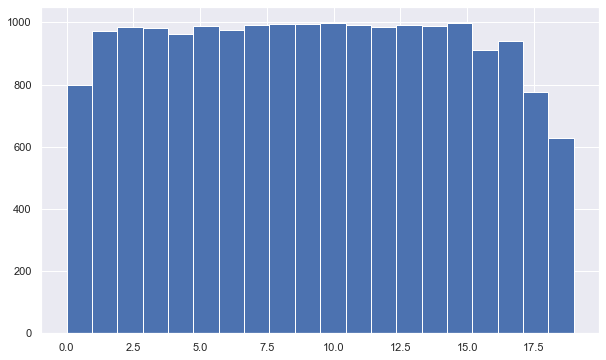

In [6]:
sns.set(rc={'figure.figsize':(10,6)})
df['target'].hist(bins=df.target.nunique())

In [7]:
#remove emails
df['text'] = df['text'].apply(lambda row: re.sub(r"\S*@\S*\s?","",row))

#remove extra spaces
df['text'] = df['text'].apply(lambda row: re.sub(r"\s+"," ",row))

# #remove single quote marks
df['text'] = df['text'].apply(lambda row: re.sub(r"\'","",row))

#make all text lower case
df['text'] = df['text'].str.lower()

#remove empty rows
# df['text'] = df[df.text != ' ']

In [8]:
df.isna().any()

text      False
target    False
dtype: bool

In [9]:
#instatiate tokenizer
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')

#tokenize test
df['tokenized_text'] = df.apply(lambda row: tokenizer.tokenize(row['text']),axis=1)

#define stop words
stop_words=set(stopwords.words("english"))

#remove stop words
df['tokenized_text'] = df['tokenized_text'].apply(lambda x: [item for item in x if item not in stop_words])

#instantiate lemmatizer
lemmatizer = WordNetLemmatizer()

#lemmatize text
df['lemmatized'] = df['tokenized_text'].apply(lambda x: [lemmatizer.lemmatize(y) for y in x])
df.lemmatized = df.lemmatized.apply(lambda x: " ".join(x) )

df.sample(5)

,text,target,tokenized_text,lemmatized
5602,one can only remap special-command keys in pro...,2,"[one, remap, special, command, keys, procomm, ...",one remap special command key procomm seems wo...
403,#in article # #>#>|>#>#theism is strongly corr...,0,"[article, theism, strongly, correlated, irrati...",article theism strongly correlated irrational ...
1624,[my stuff about dealing with defferences delet...,15,"[stuff, dealing, defferences, deleted, sorry, ...",stuff dealing defferences deleted sorry mean t...
18080,im not sure what you mean by saving face unle...,19,"[im, sure, mean, saving, face, unless, confusi...",im sure mean saving face unless confusing fbi ...
2299,"# # ""abortions destructive of the fetus must b...",18,"[abortions, destructive, fetus, must, permitte...",abortion destructive fetus must permitted even...


In [10]:
df.tokenized_text.isna().any()

False

In [11]:
#train test validation split

X,y = df.lemmatized,df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [17]:
#pipeline for logistic regression

pipe_logreg = Pipeline([
     ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression())
])
parameters_logreg = {
    'tfidf__min_df': [0.001],
    'tfidf__max_df': [0.5],
#     'tfidf__max_features': [None, 5000, 10000, 50000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],  # unigrams or bigrams
    "clf__C": [1],
    "clf__class_weight": ['balanced'],
    "clf__solver": ['newton-cg'],
#     "clf__l1_ratio":[0,0.2,0.4,0.6,0.8,1],
    "clf__multi_class":['multinomial']
}

gs_logreg = GridSearchCV(estimator=pipe_logreg,
            param_grid=parameters_logreg,
            scoring='accuracy',
            cv=KFold(5,shuffle=True,random_state=42), 
            return_train_score = True, verbose=1,n_jobs=-1)


# Fit using grid search
best_model = gs_logreg.fit(X_train, y_train)

# Best accuracy
print('Best accuracy: %.3f' % gs_logreg.best_score_)

# Best params
print('\nBest params:\n', gs_logreg.best_params_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.5min finished


Best accuracy: 0.708

Best params:
 {'clf__C': 1, 'clf__class_weight': 'balanced', 'clf__multi_class': 'multinomial', 'clf__solver': 'newton-cg', 'tfidf__max_df': 0.5, 'tfidf__min_df': 0.001, 'tfidf__ngram_range': (1, 1)}


In [13]:
pipe_logreg.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'tfidf', 'clf', 'tfidf__analyzer', 'tfidf__binary', 'tfidf__decode_error', 'tfidf__dtype', 'tfidf__encoding', 'tfidf__input', 'tfidf__lowercase', 'tfidf__max_df', 'tfidf__max_features', 'tfidf__min_df', 'tfidf__ngram_range', 'tfidf__norm', 'tfidf__preprocessor', 'tfidf__smooth_idf', 'tfidf__stop_words', 'tfidf__strip_accents', 'tfidf__sublinear_tf', 'tfidf__token_pattern', 'tfidf__tokenizer', 'tfidf__use_idf', 'tfidf__vocabulary', 'clf__C', 'clf__class_weight', 'clf__dual', 'clf__fit_intercept', 'clf__intercept_scaling', 'clf__l1_ratio', 'clf__max_iter', 'clf__multi_class', 'clf__n_jobs', 'clf__penalty', 'clf__random_state', 'clf__solver', 'clf__tol', 'clf__verbose', 'clf__warm_start'])

In [37]:
accuracy = make_scorer(accuracy_score)
precision = make_scorer(precision_score, average='macro')
recall =  make_scorer(recall_score, average='macro')
f1 = make_scorer(f1_score, average='macro')
scoring={'accuracy':accuracy,'precision':precision,'recall':recall,'f1':f1}

scoring.items()

dict_items([('accuracy', make_scorer(accuracy_score)), ('precision', make_scorer(precision_score, average=macro)), ('recall', make_scorer(recall_score, average=macro)), ('f1', make_scorer(f1_score, average=macro))])

In [35]:
from sklearn.model_selection import cross_validate

In [38]:
pipe_score_lr = Pipeline([
     ('tfidf', TfidfVectorizer(min_df=0.001,max_df=0.5,ngram_range=(1,1))),
    ('clf', LogisticRegression(C=1,class_weight='balanced',solver='newton-cg',multi_class='multinomial'))
])

cross_validate(pipe_score_lr,X_train,y_train,scoring=scoring,cv=KFold(5, shuffle=True,random_state=42),return_train_score=True)

{'fit_time': array([13.49871206, 14.37510705, 14.73576307, 13.98409486, 16.64984012]),
 'score_time': array([0.69334793, 0.59655976, 0.61283302, 0.627877  , 1.10065889]),
 'test_accuracy': array([0.71037736, 0.7       , 0.71179245, 0.70754717, 0.70801887]),
 'train_accuracy': array([0.88738208, 0.89540094, 0.88761792, 0.89693396, 0.89221698]),
 'test_precision': array([0.71612522, 0.70695954, 0.71112607, 0.70302812, 0.70849053]),
 'train_precision': array([0.89564902, 0.90168375, 0.89591286, 0.905225  , 0.89956996]),
 'test_recall': array([0.70340619, 0.69663982, 0.70323576, 0.69548515, 0.69600041]),
 'train_recall': array([0.88568811, 0.89338789, 0.8861983 , 0.89538126, 0.8908461 ]),
 'test_f1': array([0.70537418, 0.69657222, 0.70465824, 0.69679387, 0.69826575]),
 'train_f1': array([0.88849278, 0.89593279, 0.88895989, 0.8982834 , 0.89340183])}

In [55]:
def multiclass_confusion_matrix(true, pred):
    cm = confusion_matrix(true,pred)
    df_cm = pd.DataFrame(cm,
                         index = [f'TRUE_{target}' for target in list(range(0,20))],
                         columns = [f'PRED_{target}' for target in list(range(0,20))])
    sns.heatmap(df_cm, annot=True,annot_kws={'size':10},cmap='Blues',fmt='g')

In [47]:
pred_val = gs_logreg.predict(X_val)

accuracy_score: 0.7094
precision_score: 0.7094
recall_score: 0.7094
f1_score: 0.7094


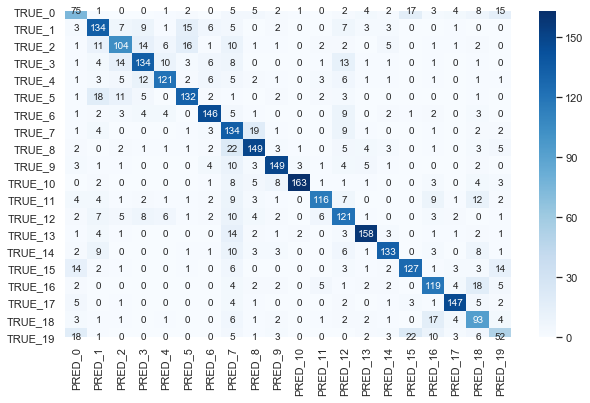

In [62]:
# plt.figure(figsize=(10,10))
multiclass_confusion_matrix(y_val,pred_val)
print(f'{accuracy_score.__name__}: {accuracy_score(y_val, pred_val):.4f}')
for scorer in [precision_score,recall_score,f1_score]:
    name = scorer.__name__
    print(f'{name}: {scorer(y_val, pred_val,average="micro"):.4f}')

In [63]:
pipe_score_lr = Pipeline([
     ('tfidf', TfidfVectorizer(min_df=3,ngram_range=(1,2))),
    ('clf', LogisticRegression(class_weight='balanced',solver='lbfgs',multi_class='multinomial'))
])

cross_validate(pipe_score_lr,X_train,y_train,scoring=scoring,cv=KFold(5, shuffle=True,random_state=42),return_train_score=True)

{'fit_time': array([20.61293387, 22.15251207, 21.16397476, 19.44701314, 20.57212186]),
 'score_time': array([0.60170913, 0.52867603, 0.49989128, 0.49340796, 0.50212312]),
 'test_accuracy': array([0.7259434 , 0.71556604, 0.72641509, 0.71933962, 0.72971698]),
 'train_accuracy': array([0.92323113, 0.93007075, 0.92523585, 0.92700472, 0.92582547]),
 'test_precision': array([0.7330033 , 0.72625334, 0.72586908, 0.71442747, 0.72895926]),
 'train_precision': array([0.93271083, 0.93783398, 0.93411256, 0.93583136, 0.93420484]),
 'test_recall': array([0.71928979, 0.71320454, 0.71615889, 0.70766547, 0.71739727]),
 'train_recall': array([0.92257543, 0.92844539, 0.92418655, 0.92576093, 0.92507803]),
 'test_f1': array([0.72088344, 0.71339775, 0.71850567, 0.70851982, 0.71978881]),
 'train_f1': array([0.92564852, 0.93161094, 0.92724161, 0.92894627, 0.92795305])}